In [1]:
import sys
import os

cd = os.getcwd()
wd = os.path.dirname(cd)
sys.path.append(os.path.join(wd,'bin'))

import libsbml
import importlib
import amici
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from modules.RunSPARCED import RunSPARCED

mpl.rcParams['figure.dpi'] = 120

### Import  and run SPARCED (hybrid) model

In [2]:
#Import SPARCED (hybrid) model

sbml_file = "SPARCED.xml"
model_name= sbml_file[0:-4]
model_output_dir = model_name
sys.path.insert(0, os.path.join(cd,model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()

species_all = list(model.getStateIds())




In [3]:
#Define stimulations
STIMligs = [1.0,0.0,0.005,0.0,0.0,0.0,0.0] # EGF, Her, HGF, PDGF, FGF, IGF, INS

STIMligs_id = ['E', 'H', 'HGF', 'P', 'F', 'I', 'INS']


In [4]:
#Define solver, time steps and initial conditions

solver = model.getSolver() # Create solver instance
solver.setMaxSteps = 1e10

ts = 30 # time step for hybrid simulation in seconds

model.setTimepoints(np.linspace(0,ts))

spIn2 = np.array(model_module.getModel().getInitialStates())

for s,sp in enumerate(STIMligs_id):
    spIn2[species_all.index(sp)] = STIMligs[s]


model.setInitialStates(spIn2)

In [5]:
#Deterministic simulation (hybrid)

flagD = 1 

th = 72

xoutS_all, xoutG_all, tout_all = RunSPARCED(flagD,th,spIn2,[],sbml_file,model)

### Import and run SPARCED (integrated-SBML) model

In [6]:
#Import SPARCED (integrated-SBML) model

fnameInput2 = 'SPARCEDo4a_v1' # model file name = USER input
sbml_file2 = fnameInput2+'.xml'
model_name2 = sbml_file2[0:-4] 
model_output_dir2 = model_name2 
sys.path.insert(0, os.path.join(cd,model_output_dir2))
model_module2 = importlib.import_module(model_name2)
model2 = model_module2.getModel()


In [7]:
#Define solver, time points and initial conditions

solver2 = model2.getSolver()
solver2.setMaxSteps = 1e10

th2 = 72*3600
model2.setTimepoints(np.linspace(0,th2,1000))

species_all2 = list(model2.getStateIds())


spIn_o4a = np.array(model_module2.getModel().getInitialStates())

for s,sp in enumerate(STIMligs_id):
    spIn_o4a[species_all2.index(sp)] = STIMligs[s]


model2.setInitialStates(spIn_o4a)

In [8]:
#Deterministic simulation (integrated-SBML)

rdata_o4a = amici.runAmiciSimulation(model2,solver2)
    

xoutS_all2 = rdata_o4a['x']
tout_all2 = rdata_o4a['t']

### Model output comparison plots

In [9]:


def timecourse_compare(xs1,xsl1,xs2,t2,xsl2,sp,ts=30,xlim=None,y0=None,ylim=None,me=10):
    t1 = np.array(range(0,len(xs1)))*30
    xt1 = xs1[:,species_all.index(sp)]
    xt2 = xs2[:,species_all2.index(sp)]
    # tout = np.array(range(len(xt1)))*ts/3600
    
    plt.plot(t1/3600,xt1,label=xsl1)
    plt.plot(t2/3600,xt2,label=xsl2,ls='None',marker="x",markevery=int(me),color='r')
    plt.ylim(0,max(max(xt1),max(xt2))*1.25)
    if type(ylim)==int or type(ylim)==float:
        plt.ylim(0,ylim)
        if type(y0)==int or type(y0)==float:
            plt.ylim(y0,ylim)
    if type(xlim)==int or type(xlim)==float:
        plt.xlim(0,xlim)
    plt.xlabel('Time (hours)')
    plt.ylabel(sp+' (nM)')
    plt.legend()
    plt.show()


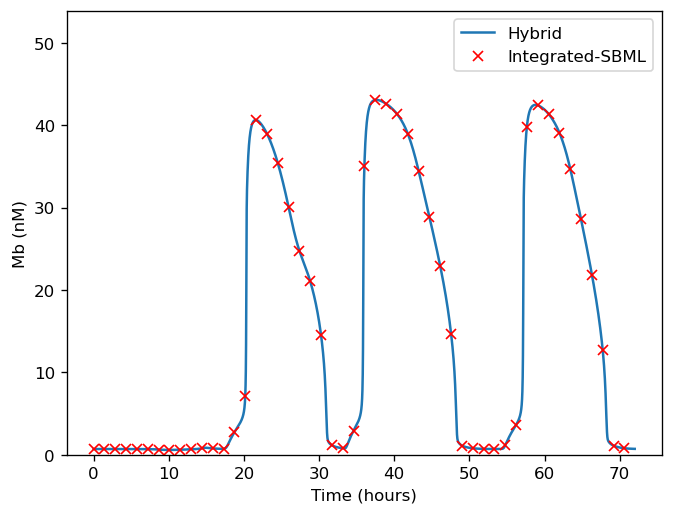

In [10]:
#Plots the species trajectory of active Cyclin B from hybrid and integrated SBML simulation results

timecourse_compare(xoutS_all,'Hybrid',xoutS_all2,tout_all2,'Integrated-SBML','Mb',me=20)

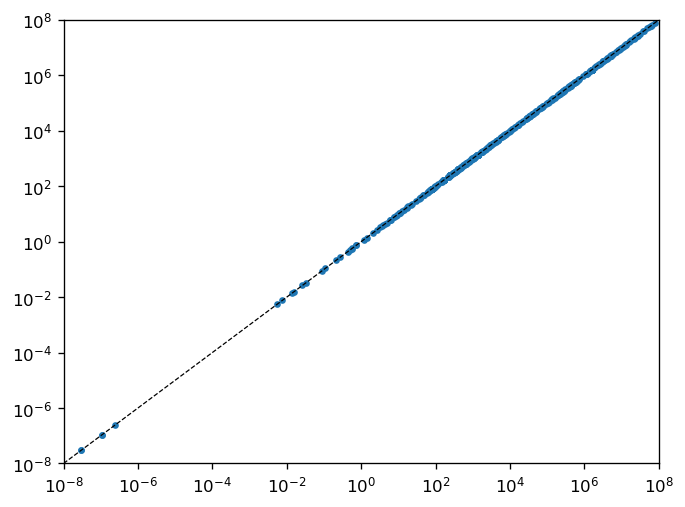

In [11]:
#Check species AUC
#Shows the aggrement between integrated-SBML and hybrid simulation results for comparable species, measured with area-under-curve for each species

auc_sparced = np.zeros(len(species_all))
auc_one4all = np.zeros(len(species_all))

for i,sp in enumerate(species_all):
    
    auc_sparced[i] = np.trapz(xoutS_all[:,species_all.index(sp)],tout_all)
    auc_one4all[i] = np.trapz(xoutS_all2[:,species_all2.index(sp)],tout_all2)
    

plt.scatter(auc_sparced,auc_one4all,marker=".")
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-8,1e8)
plt.ylim(1e-8,1e8)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints,linestyle='--', color='k', lw=0.75, scalex=False, scaley=False)
plt.show()